<a href="https://colab.research.google.com/github/Priesemann-Group/covid19_inference_forecast/blob/master/scripts/example_script_covid19_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This file create the model with three changing points of the paper https://arxiv.org/abs/2004.01105

The layout and design of the plots has been simplified in order to make the 
code more readable and more easily adaptable to other problems.

## Installation
Run this if the module isn't installed yet, or you run it in Google Colab

In [0]:
!pip install git+https://github.com/Priesemann-Group/covid19_inference_forecast.git

#Fit Model

In [5]:
import sys
import datetime

import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19

confirmed_cases = cov19.get_jhu_confirmed_cases()

country = 'Germany'
date_data_begin = datetime.datetime(2020,3,1)
date_data_end   = cov19.get_last_date(confirmed_cases)

#date_data_end   = datetime.datetime(2020,3,28)
num_days_data = (date_data_end-date_data_begin).days
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_future = 28
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
date_end_sim   = date_data_end   + datetime.timedelta(days = num_days_future)
num_days_sim = (date_end_sim-date_begin_sim).days


cases_obs = cov19.filter_one_country(confirmed_cases, country,
                                     date_data_begin, date_data_end)

prior_date_mild_dist_begin =  datetime.datetime(2020,3,9)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,16)
prior_date_contact_ban_begin =  datetime.datetime(2020,3,23)

change_points = [dict(pr_mean_date_begin_transient = prior_date_mild_dist_begin,
                      pr_sigma_date_begin_transient = 3,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 0.5),
                 dict(pr_mean_date_begin_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 0.5),
                 dict(pr_mean_date_begin_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 0.5)]

model = cov19.SIR_with_change_points(np.diff(cases_obs),
                                        change_points,
                                        date_begin_sim,
                                        num_days_sim,
                                        diff_data_sim,
                                     N=83e6)

trace = pm.sample(model=model, init='advi')


pr_beta_I_begin was set to default value 100
pr_median_lambda_0 was set to default value 0.4
pr_sigma_lambda_0 was set to default value 0.5
pr_median_mu was set to default value 0.125
pr_sigma_mu was set to default value 0.2
pr_median_delay was set to default value 8
pr_sigma_delay was set to default value 0.2
pr_beta_sigma_obs was set to default value 10
pr_median_transient_len of change point 0 was set to default value 3
pr_median_transient_len of change point 1 was set to default value 3
pr_median_transient_len of change point 2 was set to default value 3
pr_sigma_transient_len of change point 0 was set to default value 0.3
pr_sigma_transient_len of change point 1 was set to default value 0.3
pr_sigma_transient_len of change point 2 was set to default value 0.3


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 343.94:   6%|▋         | 12674/200000 [00:42<10:31, 296.82it/s]
Convergence achieved at 12700
Interrupted at 12,699 [6%]: Average Loss = 442.97
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_obs, delay, mu, transient_len_2, transient_len_1, transient_len_0, transient_begin_2, transient_begin_1, transient_begin_0, lambda_3, lambda_2, lambda_1, lambda_0, I_begin]
100%|██████████| 1000/1000 [04:57<00:00,  3.37it/s]


#Plotting

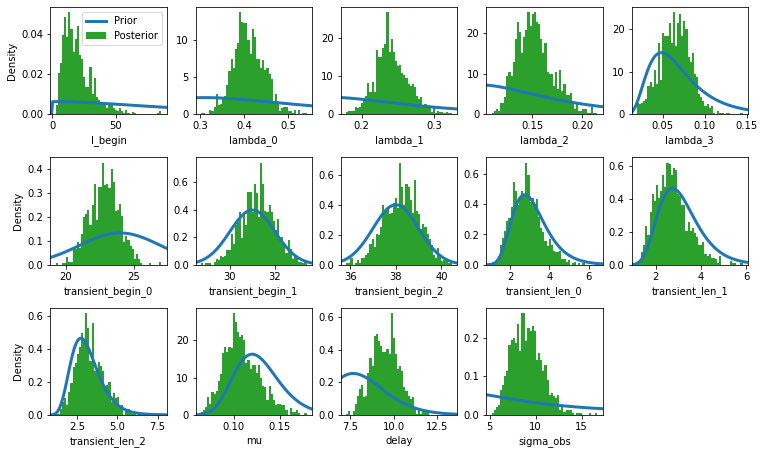

In [6]:
varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'))
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)

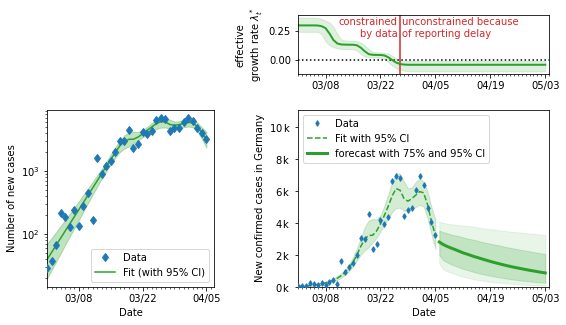

In [7]:
fig, axes = cov19.plotting.plot_cases(trace, np.diff(cases_obs), date_begin_sim, diff_data_sim,
                                      colors=('tab:blue', 'tab:green')) 